In [1]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
import utils

plt.style.use("ggplot")

# Colours for plots
COLOUR_DICT = {
    "Akvakultur": "royalblue",
    "Jordbruk": "sienna",
    "Avløp": "red",
    "Industri": "darkgrey",
    "Bebygd": "gold",
    "Bakgrunn": "limegreen",
    "Menneskeskapt": "pink",
    "Totalt": "black",
}
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=list(COLOUR_DICT.values()))

# Porsangerfjord summary data

Using TEOTIL3 to simulate nutrient inputs to the inner part of Porsangerfjorden. See e-mail from Eivind Oug received 23.01.2026 for details.

## 1. User input

In [2]:
# Define vassdragsområder of interest
vassom_dict = {
    "Stabburselva": [223],
    "Lakselva ": [224],
    "Børselvvassdraget": [225],
}

# Pars of interest
teo3_pars = ["totn", "totp", "toc", 'ss']

# Period of interest
st_yr, end_yr = 2013, 2023
nve_data_yr = 2024

# Agricultural dataset to use
agri_loss_model = "annual"

## 2. Aggregate model results to regions of interest

In [3]:
df_list = []
for area, vassom_list in vassom_dict.items():
    vassom_ids = [f"{i:03d}." for i in vassom_list]
    area_df = utils.get_teotil3_results(
        st_yr,
        end_yr,
        vassom_ids,
        agri_loss_model,
        nve_data_yr,
    )
    for par in teo3_pars:
        par_df = utils.aggregate_parameters(area_df, par).copy()
        if "Akvakultur" not in par_df.columns:
            par_df["Akvakultur"] = 0
        par_df["Menneskeskapt"] = (
            par_df["Akvakultur"]
            + par_df["Jordbruk"]
            + par_df["Avløp"]
            + par_df["Industri"]
            + par_df["Bebygd"]
        )
        par_df["Totalt"] = par_df["Menneskeskapt"] + par_df["Bakgrunn"]
        par_df = par_df.groupby("År").sum(numeric_only=True).reset_index()
        par_df["Område"] = area
        par_df["Parameter"] = par.upper()

        df_list.append(par_df)

df = pd.concat(df_list, axis="rows")
id_cols = ["Område", "Parameter", "År"]
value_cols = list(COLOUR_DICT.keys())
df = df[id_cols + value_cols]

df.to_excel("teotil3_indre_porsangerfjord_2013-2023.xlsx", index=False)

df.head()

,Område,Parameter,År,Akvakultur,Jordbruk,Avløp,Industri,Bebygd,Bakgrunn,Menneskeskapt,Totalt
0,Stabburselva,TOTN,2013,0.0,3.042093,0.72943,0.0,0.0567,145.554747,3.828223,149.382970
1,Stabburselva,TOTN,2014,0.0,2.179115,0.72943,0.0,0.0674,172.940019,2.975945,175.915964
2,Stabburselva,TOTN,2015,0.0,1.443800,0.72943,0.0,0.0531,135.991667,2.226330,138.217997
3,Stabburselva,TOTN,2016,0.0,1.416964,0.72943,0.0,0.0399,102.391094,2.186294,104.577388
4,Stabburselva,TOTN,2017,0.0,1.773254,0.72943,0.0,0.0747,191.303004,2.577384,193.880387


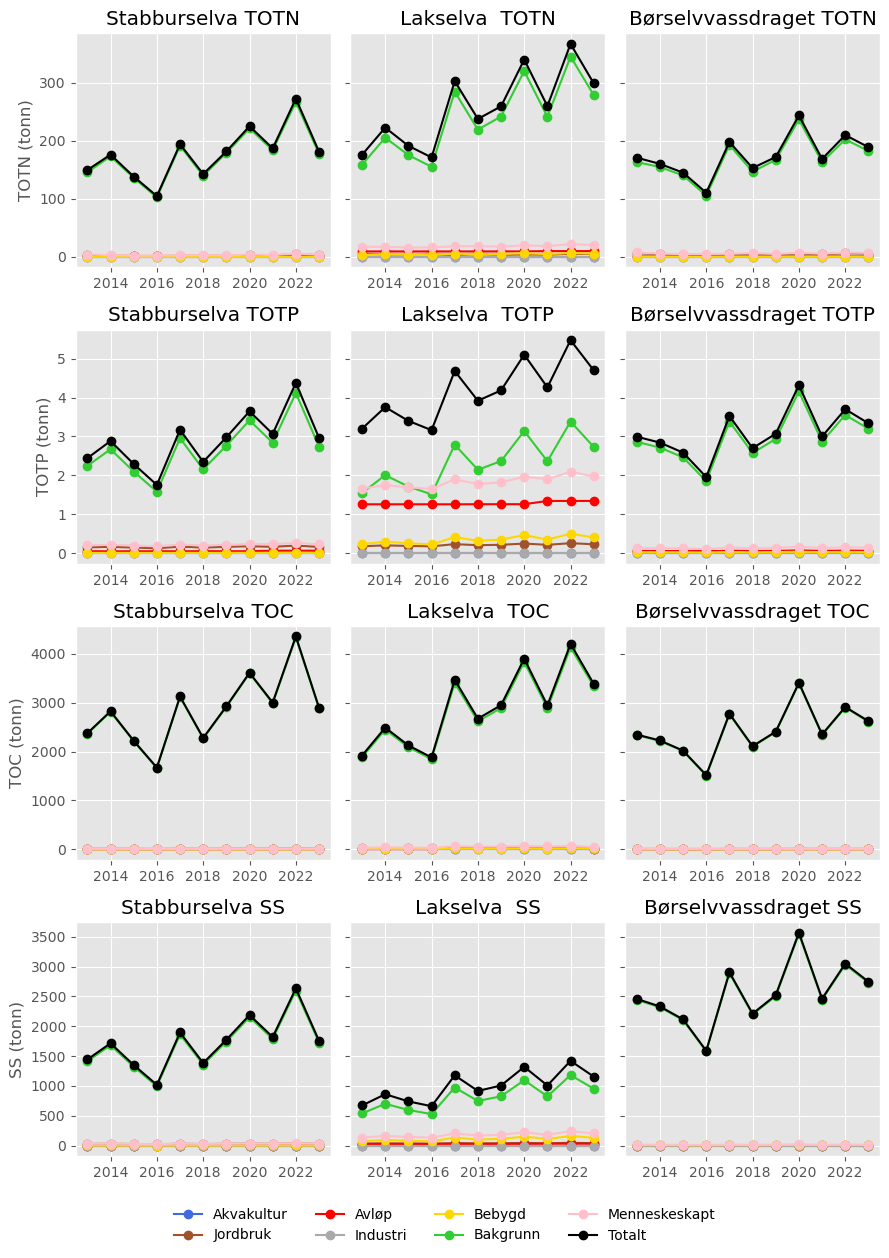

In [4]:
# Plot
ncols = len(vassom_dict.keys())
nrows=len(teo3_pars)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey="row", figsize=(ncols*3, nrows * 3))
for row_idx, area in enumerate(vassom_dict.keys()):
    for col_idx, par in enumerate(teo3_pars):
        par = par.upper()
        par_df = df.query("(`Område` == @area) and (Parameter == @par)").copy()
        par_df = par_df.drop(columns=["Område", "Parameter"]).set_index("År")
        par_df.plot(ax=axes[col_idx, row_idx], marker="o", legend=False)
        axes[col_idx, row_idx].set_title(f"{area} {par.upper()}")
        axes[col_idx, row_idx].set_xlabel("")
        axes[col_idx, row_idx].set_ylabel(f"{par.upper()} (tonn)")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=4,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05),
)

plt.tight_layout()

plt.savefig("indre_porsangerfjord_loads_2013-2023.png", dpi=200, bbox_inches="tight")

## 3. Tests for trends

For each of the `Totalt` series on the plots above, apply the Mann-Kendall and Sen's slope tests for trends.

Results from TEOTIL3 (2013 - 2023):
  Stabburselva
    TOTN: no trend (p = 0.0868)
    TOTP: no trend (p = 0.0868)
    TOC: no trend (p = 0.0868)
    SS: no trend (p = 0.0868)
  Lakselva 
    TOTN: increasing (p = 0.0127)
    TOTP: increasing (p = 0.0081)
    TOC: increasing (p = 0.0195)
    SS: increasing (p = 0.0195)
  Børselvvassdraget
    TOTN: no trend (p = 0.1611)
    TOTP: no trend (p = 0.1195)
    TOC: no trend (p = 0.1195)
    SS: no trend (p = 0.1195)


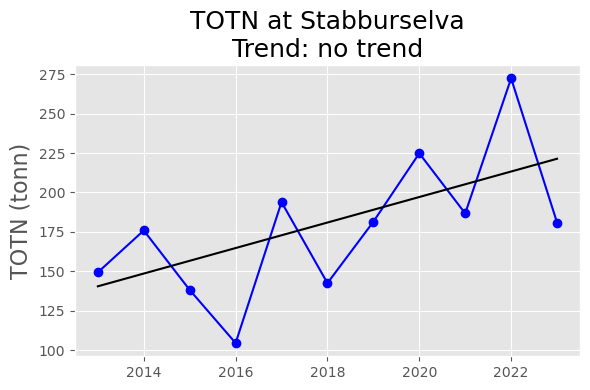

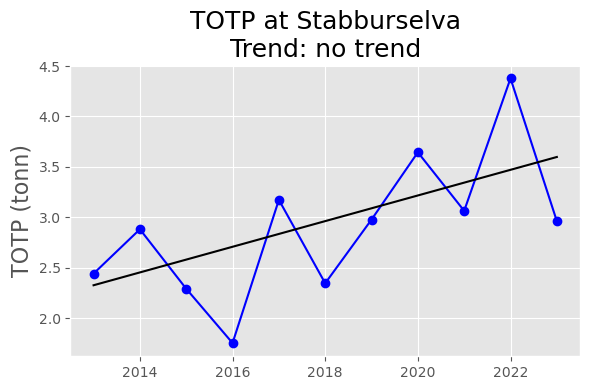

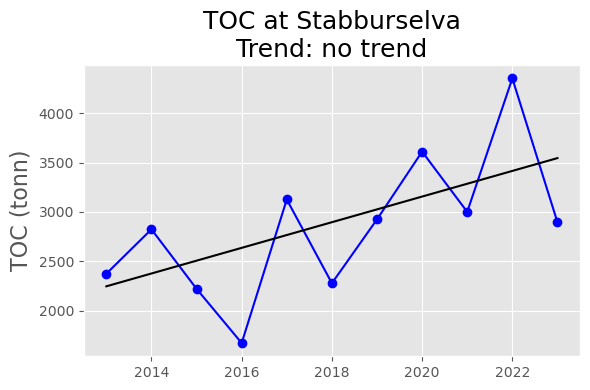

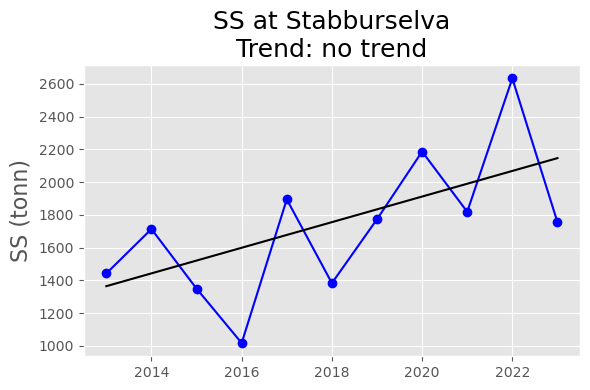

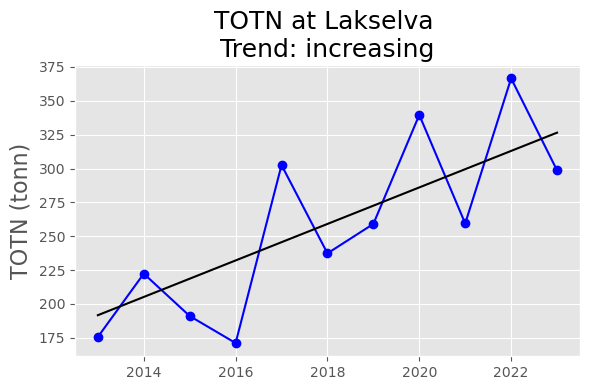

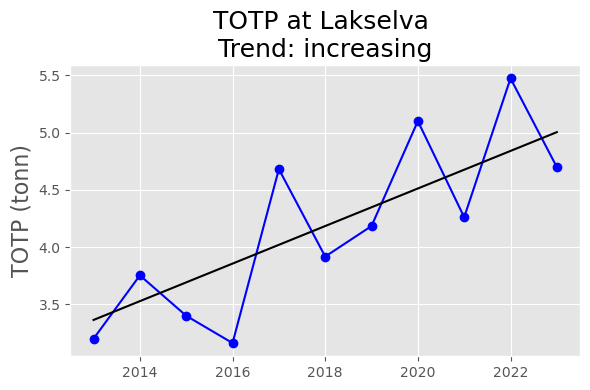

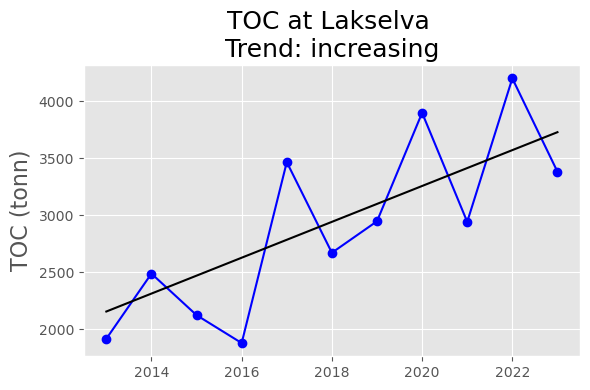

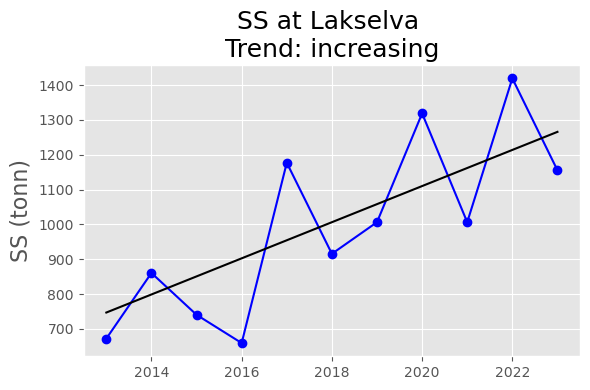

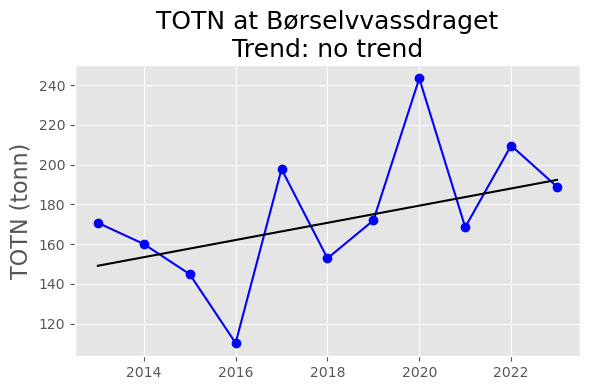

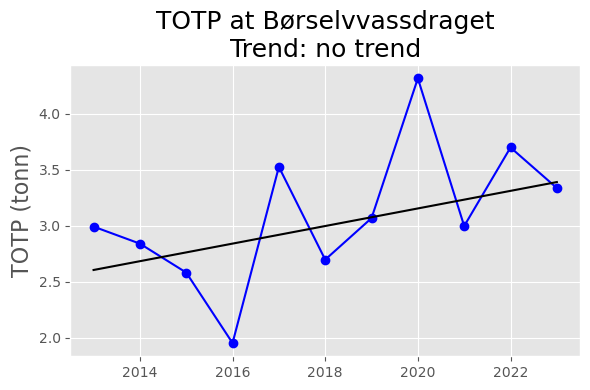

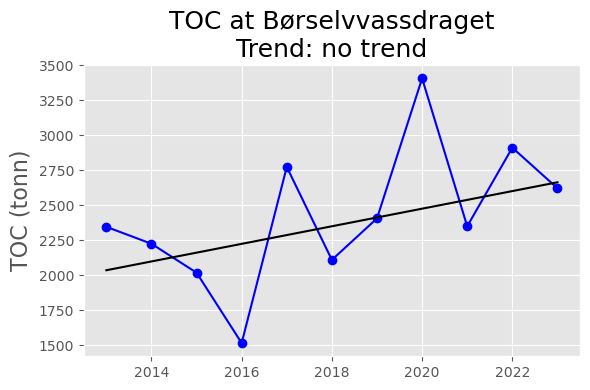

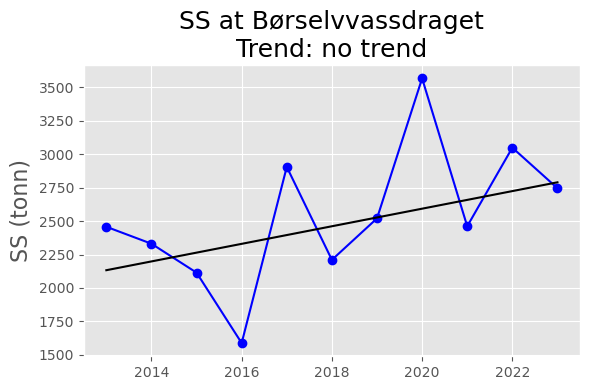

In [5]:
# Test for trends in 'Totalt'
print("Results from TEOTIL3 (2013 - 2023):")
for area in vassom_dict.keys():
    print(f"  {area}")
    for par in teo3_pars:
        par = par.upper()
        par_df = df.query("(`Område` == @area) and (Parameter == @par)").copy()
        mk_df = nivapy.stats.mk_test(par_df, 'Totalt', alpha=0.05)
        trend = mk_df.loc["trend", "value"]
        pval = mk_df.loc["p", "value"]
        res_df, sen_df = nivapy.stats.sens_slope(
            par_df, 'Totalt', index_col="År", alpha=0.05
        )
        nivapy.plotting.plot_sens_slope(
            res_df,
            sen_df,
            ylabel=f"{par} (tonn)",
            title=f"{par} at {area}\nTrend: {trend}",
        )

        print(f"    {par}: {trend} (p = {pval:.4f})")